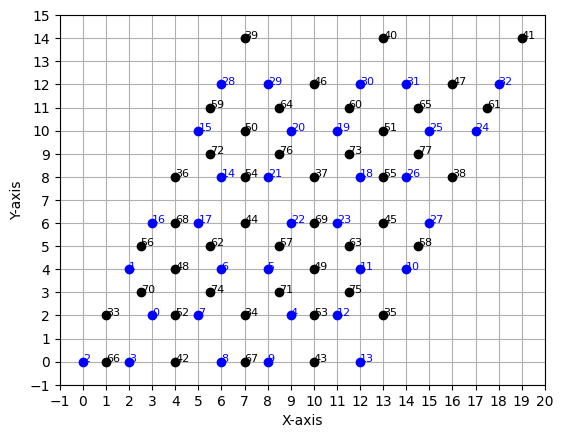

All Qubits (Index: (x,y)):
0 (3, 2)
1 (2, 4)
2 (0, 0)
3 (2, 0)
4 (9, 2)
5 (8, 4)
6 (6, 4)
7 (5, 2)
8 (6, 0)
9 (8, 0)
10 (14, 4)
11 (12, 4)
12 (11, 2)
13 (12, 0)
14 (6, 8)
15 (5, 10)
16 (3, 6)
17 (5, 6)
18 (12, 8)
19 (11, 10)
20 (9, 10)
21 (8, 8)
22 (9, 6)
23 (11, 6)
24 (17, 10)
25 (15, 10)
26 (14, 8)
27 (15, 6)
28 (6, 12)
29 (8, 12)
30 (12, 12)
31 (14, 12)
32 (18, 12)
33 (1, 2)
34 (7, 2)
35 (13, 2)
36 (4, 8)
37 (10, 8)
38 (16, 8)
39 (7, 14)
40 (13, 14)
41 (19, 14)
42 (4, 0)
43 (10, 0)
44 (7, 6)
45 (13, 6)
46 (10, 12)
47 (16, 12)
48 (4, 4)
49 (10, 4)
50 (7, 10)
51 (13, 10)
52 (4, 2)
53 (10, 2)
54 (7, 8)
55 (13, 8)
56 (2.5, 5)
57 (8.5, 5)
58 (14.5, 5)
59 (5.5, 11)
60 (11.5, 11)
61 (17.5, 11)
62 (5.5, 5)
63 (11.5, 5)
64 (8.5, 11)
65 (14.5, 11)
66 (1, 0)
67 (7, 0)
68 (4, 6)
69 (10, 6)
70 (2.5, 3)
71 (8.5, 3)
72 (5.5, 9)
73 (11.5, 9)
74 (5.5, 3)
75 (11.5, 3)
76 (8.5, 9)
77 (14.5, 9)


In [680]:
import matplotlib.pyplot as plt

# パラメータ
d = 5
n = (d + 1) / 2  # n = 3
n = int(n)        # nが整数になるように

# 基準座標の初期値 (1,2)
base_x, base_y = 1, 2

# ベクトル (3,6) を n-1 回足して生成する基準点
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n)]

# 移動量(方向)
shift_dx, shift_dy = 6, 0

# directionの定義
directions = [(2, 0), (1, 2), (-1, 2), (-2, 0), (-1, -2), (1, -2)]

# 結果格納用リスト
data_qubits = []    # 基準点じゃない点
ancilla_qubits = [] # 基準点

# === 最初のブロック ===
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n):
        # 条件に応じて方向を調整
        if step == 0:  # 0回目
            filtered_directions = [(2, 0), (1, 2), (-1, -2), (1, -2)]
        elif step == n - 1:  # 最後の回
            filtered_directions = [(1, 2), (-1, 2), (-2, 0), (-1, -2)]
        else:  # その他の回
            filtered_directions = directions

        # 特別な条件: 最後の基準点の場合
        if point_index == len(initial_base_points) - 1:
            if step == n - 1:  # 最後の移動後
                filtered_directions = [(-1, -2)]  # (1, -2) を除外
            else:
                filtered_directions = [(-1, -2), (1, -2)]  # 通常時

        # 基準点をancillaに登録
        ancilla_qubits.append((base_x_current, base_y_current))

        # directionに基づく点をdataに登録
        for dx, dy in filtered_directions:
            new_x = base_x_current + dx
            new_y = base_y_current + dy
            data_qubits.append((new_x, new_y))

        # 次のステップがある場合は基準点を(6,0)方向にシフト
        base_x_current += shift_dx
        base_y_current += shift_dy


# === 二つ目以降のブロック ===
# 同様に基準点のみ追加 (ancilla) で、方向への点(data)はなしのように見えるので
# 同様の処理を行う

base_x, base_y = 4, 0
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n)]
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n-1):
        ancilla_qubits.append((base_x_current, base_y_current))
        base_x_current += shift_dx
        base_y_current += shift_dy

base_x, base_y = 4, 4
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n-1)]
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n-1):
        ancilla_qubits.append((base_x_current, base_y_current))
        base_x_current += shift_dx
        base_y_current += shift_dy

base_x, base_y = 4, 2
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n-1)]
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n-1):
        ancilla_qubits.append((base_x_current, base_y_current))
        base_x_current += shift_dx
        base_y_current += shift_dy

base_x, base_y = 2.5, 5
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n-1)]
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n):
        ancilla_qubits.append((base_x_current, base_y_current))
        base_x_current += shift_dx
        base_y_current += shift_dy

base_x, base_y = 5.5, 5
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n-1)]
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n-1):
        ancilla_qubits.append((base_x_current, base_y_current))
        base_x_current += shift_dx
        base_y_current += shift_dy

base_x, base_y = 1, 0
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n-1)]
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n-1):
        ancilla_qubits.append((base_x_current, base_y_current))
        base_x_current += shift_dx
        base_y_current += shift_dy

base_x, base_y = 2.5, 3
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n-1)]
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n-1):
        ancilla_qubits.append((base_x_current, base_y_current))
        base_x_current += shift_dx
        base_y_current += shift_dy

base_x, base_y = 5.5, 3
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n-1)]
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n-1):
        ancilla_qubits.append((base_x_current, base_y_current))
        base_x_current += shift_dx
        base_y_current += shift_dy


# === 番号付け ===
# data_qubitsに0から順に番号をつけ、その後ancilla_qubitsに連続する番号を付ける
data_qubit_dict = {i: coord for i, coord in enumerate(data_qubits)}
ancilla_qubit_dict_start = len(data_qubits)  # ancillaはdataのあと
ancilla_qubit_dict = {ancilla_qubit_dict_start + i: coord for i, coord in enumerate(ancilla_qubits)}

# 全てのqubit情報を統合 (必要であれば)
all_qubits_dict = {**data_qubit_dict, **ancilla_qubit_dict}


# === プロット ===
fig, ax = plt.subplots()

# data_qubitsは青でプロット
for idx, (x,y) in data_qubit_dict.items():
    ax.plot(x, y, 'bo')
    ax.text(x, y, str(idx), color='blue', fontsize=8)

# ancilla_qubitsは黒でプロット
for idx, (x,y) in ancilla_qubit_dict.items():
    ax.plot(x, y, 'ko')
    ax.text(x, y, str(idx), color='black', fontsize=8)

# 軸の範囲をある程度自動調整
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True)

# 軸目盛りを整数に
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

x_min = int(x_min) - 1
x_max = int(x_max) + 1
y_min = int(y_min) - 1
y_max = int(y_max) + 1

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.set_xticks(range(int(x_min), int(x_max)+1))
ax.set_yticks(range(int(y_min), int(y_max)+1))

plt.show()

# 必要に応じてall_qubits_dictを出力
print("All Qubits (Index: (x,y)):")
for k,v in all_qubits_dict.items():
    print(k, v)


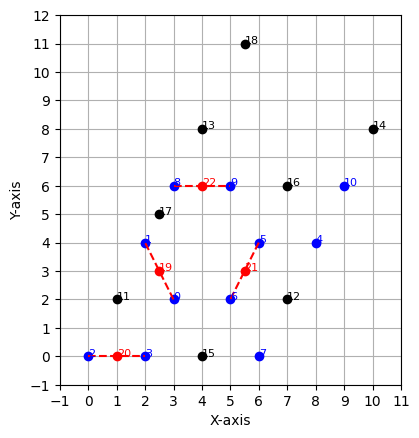

blue_Z_edge (After deduplication): {A:(B,B')}
19 : (0, 1)
20 : (2, 3)
21 : (5, 6)
22 : (8, 9)
Total Qubits after deduplication: 23


In [681]:
import matplotlib.pyplot as plt

# パラメータ
d = 3
n = (d + 1) / 2  # n = 3
n = int(n)

shift_dx, shift_dy = 6, 0
directions = [(2, 0), (1, 2), (-1, 2), (-2, 0), (-1, -2), (1, -2)]
paired_direction_sets = [
    [(2, 0), (1, 2)],
    [(-1, 2), (-2, 0)],
    [(-1, -2), (1, -2)]
]

# 最初にdata_qubits, ancilla_qubitsを生成し、direction_mapも作る
data_qubits = []
ancilla_qubits = []
direction_map = []  # 各ancilla生成回に使用したdirectionと生成されたdata_qubitインデックスの対応

base_x, base_y = 1, 2
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n)]
current_data_index = 0

for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n):
        if step == 0:
            filtered_directions = [(2, 0), (1, 2), (-1, -2), (1, -2)]
        elif step == n - 1:
            filtered_directions = [(1, 2), (-1, 2), (-2, 0), (-1, -2)]
        else:
            filtered_directions = directions

        if point_index == len(initial_base_points) - 1:
            if step == n - 1:
                filtered_directions = [(-1, -2)]
            else:
                filtered_directions = [(-1, -2), (1, -2)]

        ancilla_qubits.append((base_x_current, base_y_current))
        temp_dir_record = []
        for dx, dy in filtered_directions:
            new_x = base_x_current + dx
            new_y = base_y_current + dy
            data_qubits.append((new_x, new_y))
            temp_dir_record.append((dx, dy, current_data_index))
            current_data_index += 1

        direction_map.append(temp_dir_record)
        base_x_current += shift_dx
        base_y_current += shift_dy

# 続くancillaのみ追加のブロック
base_sets = [
    (4,0,n),
    (4,4,n-1),
    (4,2,n-1),
    (2.5,5,n),
    (5.5,5,n-1),
    (1,0,n-1),
    (2.5,3,n-1),
    (5.5,3,n-1),
]

for (bx, by, steps) in base_sets:
    initial_base_points = [(bx + 3 * i, by + 6 * i) for i in range(steps)]
    for p_i, (ibx, iby) in enumerate(initial_base_points):
        base_x_current = ibx
        base_y_current = iby
        for step in range(steps-1 if steps>1 else 0):
            ancilla_qubits.append((base_x_current, base_y_current))
            base_x_current += shift_dx
            base_y_current += shift_dy

data_qubit_dict = {i: coord for i, coord in enumerate(data_qubits)}
ancilla_qubit_dict_start = len(data_qubits)
ancilla_qubit_dict = {ancilla_qubit_dict_start + i: coord for i, coord in enumerate(ancilla_qubits)}
all_qubits_dict = {**data_qubit_dict, **ancilla_qubit_dict}

# blue_Z_edge(A:(B,B'))を求める（元のpair_ancilla_mapの代わり）
blue_Z_edge = {}

# 中点アンシラ生成
for ancilla_num, record in enumerate(direction_map):
    # record: [(dx,dy,data_idx),...]
    for pair_dirs in paired_direction_sets:
        indices_found = []
        for (dx,dy) in pair_dirs:
            for (rdx,rdy,di) in record:
                if rdx == dx and rdy == dy:
                    indices_found.append(di)
                    break
        if len(indices_found) == 2:
            B, Bp = indices_found
            x1,y1 = data_qubit_dict[B]
            x2,y2 = data_qubit_dict[Bp]
            mid_x = (x1+x2)/2.0
            mid_y = (y1+y2)/2.0
            # 新中点アンシラ追加
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (mid_x, mid_y)
            blue_Z_edge[A_index] = (B,Bp)

# ===== 重複アンシラを排除する処理 =====
ancilla_start_index = ancilla_qubit_dict_start
ancilla_indices = [i for i in all_qubits_dict.keys() if i >= ancilla_start_index]
coord_to_ancilla_index = {}
duplicates = {}

for A in ancilla_indices:
    coord = all_qubits_dict[A]
    if coord not in coord_to_ancilla_index:
        coord_to_ancilla_index[coord] = A
    else:
        # 重複アンシラ
        original_A = coord_to_ancilla_index[coord]
        duplicates[A] = original_A

# blue_Z_edge中の参照を更新
for A in list(blue_Z_edge.keys()):
    if A in duplicates:
        # このAは重複なので統合先へ
        new_A = duplicates[A]
        if new_A in blue_Z_edge:
            # すでに新Aにペアが登録されている場合は統合が必要だが、
            # ここでは元Aのペアは無視するか、上書きしない。
            # 必要に応じて統合処理を書くことができる。
            pass
        else:
            blue_Z_edge[new_A] = blue_Z_edge[A]
        del blue_Z_edge[A]

# all_qubits_dictから重複Aを削除
for A in duplicates.keys():
    del all_qubits_dict[A]

# ===== プロット =====

fig, ax = plt.subplots()

# data_qubitsは青
for i,(x,y) in data_qubit_dict.items():
    ax.plot(x, y, 'bo')
    ax.text(x, y, str(i), color='blue', fontsize=8)

# 重複削除後のall_qubits_dictからancillaを特定
new_ancilla_indices = [i for i in all_qubits_dict if i >= ancilla_start_index]

# blue_Z_edgeにあるアンシラは赤、中点以外のアンシラは黒
for A_index in new_ancilla_indices:
    xA,yA = all_qubits_dict[A_index]
    if A_index in blue_Z_edge:
        # 中点アンシラ（ペアに登場）
        ax.plot(xA, yA, 'ro')
        ax.text(xA, yA, str(A_index), color='red', fontsize=8)
        B,Bp = blue_Z_edge[A_index]
        xB,yB = data_qubit_dict[B]
        xBp,yBp = data_qubit_dict[Bp]
        ax.plot([xB,xA,xBp],[yB,yA,yBp],'r--')
    else:
        # 通常アンシラ
        ax.plot(xA, yA, 'ko')
        ax.text(xA, yA, str(A_index), color='black', fontsize=8)

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True)

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

x_min = int(x_min) - 1
x_max = int(x_max) + 1
y_min = int(y_min) - 1
y_max = int(y_max) + 1

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.set_xticks(range(int(x_min), int(x_max)+1))
ax.set_yticks(range(int(y_min), int(y_max)+1))

plt.show()

print("blue_Z_edge (After deduplication): {A:(B,B')}")
for A,(B,Bp) in blue_Z_edge.items():
    print(A,":", (B,Bp))

print("Total Qubits after deduplication:", len(all_qubits_dict))


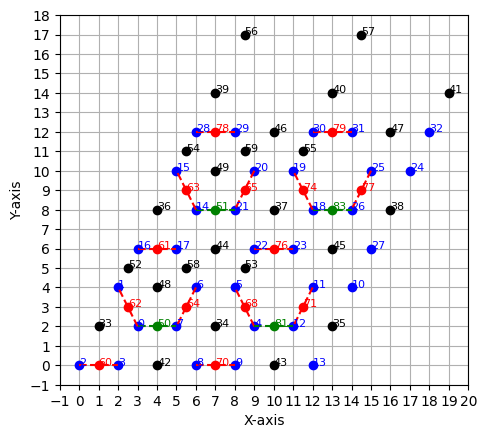

blue_Z_edge (After deduplication): {A:(B,B')}
68 : (4, 5)
70 : (8, 9)
71 : (11, 12)
74 : (18, 19)
76 : (22, 23)
77 : (25, 26)
78 : (28, 29)
79 : (30, 31)
62 : (0, 1)
60 : (2, 3)
64 : (6, 7)
63 : (14, 15)
61 : (16, 17)
65 : (20, 21)
green_X_edge (After deduplication): {A:(B,B')}
81 : (4, 12)
83 : (18, 26)
50 : (0, 7)
51 : (14, 21)
Total Qubits after deduplication: 76


In [682]:
import matplotlib.pyplot as plt

# パラメータ
d = 5
n = (d + 1) / 2  # n = 3
n = int(n)

shift_dx, shift_dy = 6, 0
directions = [(2, 0), (1, 2), (-1, 2), (-2, 0), (-1, -2), (1, -2)]
paired_direction_sets = [
    [(2, 0), (1, 2)],
    [(-1, 2), (-2, 0)],
    [(-1, -2), (1, -2)]
]

# データ格納用
data_qubits = []
ancilla_qubits = []
direction_map = []  # 各ancilla生成毎の(direction,生成data qubit index)記録

base_x, base_y = 1, 2
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n)]
current_data_index = 0

# --- 最初のブロック(ancilla + data生成) ---
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n):
        if step == 0:
            filtered_directions = [(2, 0), (1, 2), (-1, -2), (1, -2)]
        elif step == n - 1:
            filtered_directions = [(1, 2), (-1, 2), (-2, 0), (-1, -2)]
        else:
            filtered_directions = directions

        if point_index == len(initial_base_points) - 1:
            if step == n - 1:
                filtered_directions = [(-1, -2)]
            else:
                filtered_directions = [(-1, -2), (1, -2)]

        # Ancilla登録
        ancilla_qubits.append((base_x_current, base_y_current))
        temp_dir_record = []
        for dx, dy in filtered_directions:
            new_x = base_x_current + dx
            new_y = base_y_current + dy
            data_qubits.append((new_x, new_y))
            temp_dir_record.append((dx, dy, current_data_index))
            current_data_index += 1

        direction_map.append(temp_dir_record)
        base_x_current += shift_dx
        base_y_current += shift_dy

# --- その後のブロック(ancillaのみ) ---
base_sets = [
    (4,0,n),
    (4,4,n-1),
    (4,2,n-1),
    (2.5,5,n),
    (5.5,5,n-1),
    (1,0,n-1),
    (2.5,3,n-1),
    (5.5,3,n-1),
]

for (bx, by, steps) in base_sets:
    initial_base_points = [(bx + 3 * i, by + 6 * i) for i in range(steps)]
    for p_i, (ibx, iby) in enumerate(initial_base_points):
        base_x_current = ibx
        base_y_current = iby
        for step in range(steps-1 if steps>1 else 0):
            ancilla_qubits.append((base_x_current, base_y_current))
            base_x_current += shift_dx
            base_y_current += shift_dy

data_qubit_dict = {i: coord for i, coord in enumerate(data_qubits)}
ancilla_qubit_dict_start = len(data_qubits)
ancilla_qubit_dict = {ancilla_qubit_dict_start + i: coord for i, coord in enumerate(ancilla_qubits)}
all_qubits_dict = {**data_qubit_dict, **ancilla_qubit_dict}

# blue_Z_edge生成
blue_Z_edge = {}
for ancilla_num, record in enumerate(direction_map):
    # record: [(dx,dy,data_idx), ...]
    for pair_dirs in paired_direction_sets:
        indices_found = []
        for (dx,dy) in pair_dirs:
            for (rdx,rdy,di) in record:
                if rdx == dx and rdy == dy:
                    indices_found.append(di)
                    break
        if len(indices_found) == 2:
            B, Bp = indices_found
            x1,y1 = data_qubit_dict[B]
            x2,y2 = data_qubit_dict[Bp]
            mid_x = (x1+x2)/2.0
            mid_y = (y1+y2)/2.0
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (mid_x, mid_y)
            blue_Z_edge[A_index] = (B,Bp)

# ===== green_X_edge生成 =====
# green_X_edgeは、連続するancilla間で (2,0) と (-2,0) データ点をペアにする
green_X_edge = {}
# direction_map[i]対応のancillaはancilla_qubits[i] (最初の大ブロックに対して)
# 連続するancilla i, i+1 で、i番目のancillaに(2,0)があり、i+1番目のancillaに(-2,0)があるか探す
for i in range(len(direction_map)-1):
    # i番目のancilla
    record_curr = direction_map[i]
    # i+1番目のancilla
    record_next = direction_map[i+1]

    B = None
    Bp = None
    # i番目から(2,0)を探す
    for (rdx,rdy,di) in record_curr:
        if (rdx,rdy) == (2,0):
            B = di
            break

    # i+1番目から(-2,0)を探す
    for (rdx,rdy,di) in record_next:
        if (rdx,rdy) == (-2,0):
            Bp = di
            break

    if B is not None and Bp is not None:
        # 中点ancillaを作る
        # 中点はancilla_qubits[i]とancilla_qubits[i+1]の中点
        xA1,yA1 = ancilla_qubits[i]
        xA2,yA2 = ancilla_qubits[i+1]
        mid_x = (xA1 + xA2)/2.0
        mid_y = (yA1 + yA2)/2.0
        A_index = len(all_qubits_dict)
        all_qubits_dict[A_index] = (mid_x, mid_y)
        green_X_edge[A_index] = (B,Bp)

# ===== 重複アンシラ削除 =====
ancilla_start_index = ancilla_qubit_dict_start
ancilla_indices = [idx for idx in all_qubits_dict if idx >= ancilla_start_index]
coord_to_ancilla_index = {}
duplicates = {}

for A in ancilla_indices:
    coord = all_qubits_dict[A]
    if coord not in coord_to_ancilla_index:
        coord_to_ancilla_index[coord] = A
    else:
        # 重複アンシラ
        original_A = coord_to_ancilla_index[coord]
        duplicates[A] = original_A

# blue_Z_edge中の参照更新
for A in list(blue_Z_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A in blue_Z_edge:
            # すでにnew_Aがペアを持つ場合はここで統合処理可能
            # ここでは元Aのペアは破棄
            pass
        else:
            blue_Z_edge[new_A] = blue_Z_edge[A]
        del blue_Z_edge[A]

# green_X_edge中の参照更新
for A in list(green_X_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A in green_X_edge:
            # 同様に統合処理可能だが、ここでは元Aのペアは無視
            pass
        else:
            green_X_edge[new_A] = green_X_edge[A]
        del green_X_edge[A]

# all_qubits_dictから重複Aを削除
for A in duplicates.keys():
    del all_qubits_dict[A]

# ===== プロット =====
fig, ax = plt.subplots()

# data_qubitsは青
for i,(x,y) in data_qubit_dict.items():
    ax.plot(x, y, 'bo')
    ax.text(x, y, str(i), color='blue', fontsize=8)

# 重複削除後のancilla再取得
new_ancilla_indices = [i for i in all_qubits_dict if i >= ancilla_start_index]

# 通常アンシラ(黒)
for A_index in new_ancilla_indices:
    if A_index not in blue_Z_edge and A_index not in green_X_edge:
        xA,yA = all_qubits_dict[A_index]
        ax.plot(xA, yA, 'ko')
        ax.text(xA, yA, str(A_index), color='black', fontsize=8)

# blue_Z_edge(赤)
for A_index,(B,Bp) in blue_Z_edge.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'ro')
    ax.text(xA, yA, str(A_index), color='red', fontsize=8)
    xB,yB = data_qubit_dict[B]
    xBp,yBp = data_qubit_dict[Bp]
    ax.plot([xB,xA,xBp],[yB,yA,yBp],'r--')

# green_X_edge(緑)
for A_index,(B,Bp) in green_X_edge.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'go')
    ax.text(xA, yA, str(A_index), color='green', fontsize=8)
    xB,yB = data_qubit_dict[B]
    xBp,yBp = data_qubit_dict[Bp]
    ax.plot([xB,xA,xBp],[yB,yA,yBp],'g--')

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True)

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

x_min = int(x_min) - 1
x_max = int(x_max) + 1
y_min = int(y_min) - 1
y_max = int(y_max) + 1

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.set_xticks(range(int(x_min), int(x_max)+1))
ax.set_yticks(range(int(y_min), int(y_max)+1))

plt.show()

print("blue_Z_edge (After deduplication): {A:(B,B')}")
for A,(B,Bp) in blue_Z_edge.items():
    print(A,":", (B,Bp))

print("green_X_edge (After deduplication): {A:(B,B')}")
for A,(B,Bp) in green_X_edge.items():
    print(A,":", (B,Bp))

print("Total Qubits after deduplication:", len(all_qubits_dict))


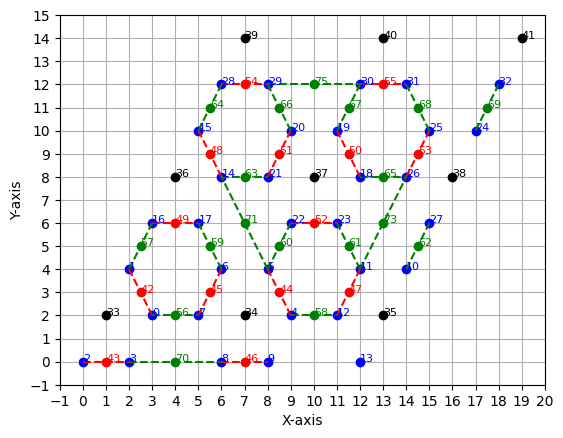

blue_Z_edge (After deduplication): {A:(B,B')}
42 : (0, 1)
43 : (2, 3)
44 : (4, 5)
45 : (6, 7)
46 : (8, 9)
47 : (11, 12)
48 : (14, 15)
49 : (16, 17)
50 : (18, 19)
51 : (20, 21)
52 : (22, 23)
53 : (25, 26)
54 : (28, 29)
55 : (30, 31)
green_X_edge (After deduplication): {A:(B,B')}
56 : (0, 7)
57 : (1, 16)
58 : (4, 12)
59 : (6, 17)
60 : (5, 22)
61 : (11, 23)
62 : (10, 27)
63 : (14, 21)
64 : (15, 28)
65 : (18, 26)
66 : (20, 29)
67 : (19, 30)
68 : (25, 31)
69 : (24, 32)
70 : (3, 8)
71 : (5, 14)
73 : (11, 26)
75 : (29, 30)
Total Qubits after deduplication: 74


In [683]:
import matplotlib.pyplot as plt
import math

# パラメータ
d = 5
n = (d + 1) / 2  # n = 3
n = int(n)

shift_dx, shift_dy = 6, 0
directions = [(2, 0), (1, 2), (-1, 2), (-2, 0), (-1, -2), (1, -2)]
paired_direction_sets = [
    [(2, 0), (1, 2)],
    [(-1, 2), (-2, 0)],
    [(-1, -2), (1, -2)]
]

# データ格納用
data_qubits = []
ancilla_qubits = []
direction_map = []  # 各ancilla生成毎の(direction,生成data qubit index)記録

base_x, base_y = 1, 2
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n)]
current_data_index = 0

# --- 最初のブロック(ancilla + data生成) ---
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n):
        if step == 0:
            filtered_directions = [(2, 0), (1, 2), (-1, -2), (1, -2)]
        elif step == n - 1:
            filtered_directions = [(1, 2), (-1, 2), (-2, 0), (-1, -2)]
        else:
            filtered_directions = directions

        if point_index == len(initial_base_points) - 1:
            if step == n - 1:
                filtered_directions = [(-1, -2)]
            else:
                filtered_directions = [(-1, -2), (1, -2)]

        # Ancilla登録（基準点）
        ancilla_qubits.append((base_x_current, base_y_current))
        temp_dir_record = []
        for dx, dy in filtered_directions:
            new_x = base_x_current + dx
            new_y = base_y_current + dy
            data_qubits.append((new_x, new_y))
            temp_dir_record.append((dx, dy, current_data_index))
            current_data_index += 1

        direction_map.append(temp_dir_record)
        base_x_current += shift_dx
        base_y_current += shift_dy

# ここでは例として追加アンシラなしとしているが、必要なら他ブロック処理を挿入可能

# Data, Ancillaを辞書化
data_qubit_dict = {i: coord for i, coord in enumerate(data_qubits)}
ancilla_qubit_dict_start = len(data_qubits)
ancilla_qubit_dict = {ancilla_qubit_dict_start + i: coord for i, coord in enumerate(ancilla_qubits)}
all_qubits_dict = {**data_qubit_dict, **ancilla_qubit_dict}

# blue_Z_edge計算 (ペア方向による中点アンシラ)
blue_Z_edge = {}
# 中点アンシラ生成(blue_Z_edge) 
for ancilla_num, record in enumerate(direction_map):
    # record: [(dx,dy,data_idx),...]
    for pair_dirs in paired_direction_sets:
        indices_found = []
        for (dx,dy) in pair_dirs:
            for (rdx,rdy,di) in record:
                if rdx == dx and rdy == dy:
                    indices_found.append(di)
                    break
        if len(indices_found) == 2:
            B, Bp = indices_found
            x1,y1 = data_qubit_dict[B]
            x2,y2 = data_qubit_dict[Bp]
            mid_x = (x1+x2)/2.0
            mid_y = (y1+y2)/2.0
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (mid_x, mid_y)
            blue_Z_edge[A_index] = (B,Bp)

# 重複アンシラ削除
ancilla_start_index = ancilla_qubit_dict_start
ancilla_indices = [i for i in all_qubits_dict.keys() if i >= ancilla_start_index]
coord_to_ancilla_index = {}
duplicates = {}

for A in ancilla_indices:
    coord = all_qubits_dict[A]
    if coord not in coord_to_ancilla_index:
        coord_to_ancilla_index[coord] = A
    else:
        original_A = coord_to_ancilla_index[coord]
        duplicates[A] = original_A

for A in list(blue_Z_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A in blue_Z_edge:
            # 既に新Aがペアを持つ場合はここでは元Aのペアは無視
            pass
        else:
            blue_Z_edge[new_A] = blue_Z_edge[A]
        del blue_Z_edge[A]

for A in duplicates.keys():
    del all_qubits_dict[A]

# 再マップ
data_qubit_dict = {i: v for i,v in all_qubits_dict.items() if i < ancilla_start_index}
ancilla_qubit_dict = {i: v for i,v in all_qubits_dict.items() if i >= ancilla_start_index}

# === green_X_edge計算 ===
# 基準点(最初のブロックで生成されたancilla)のみ対象。
# 今回は全ancilla_qubit_dictが最初のブロックのものと仮定する。
green_X_edge = {}

# 基準点ペアで距離が6または3√5 -> dist²が36または45
def on_line_segment(x1,y1,x2,y2,xd,yd):
    dx = x2 - x1
    dy = y2 - y1
    if dx == 0 and dy == 0:
        return False, None
    if dx != 0:
        t = (xd - x1)/dx
        # yd - y1 = t*dy確認
        if abs((yd - y1) - t*dy) < 1e-9 and 0 < t < 1:
            return True, t
    else:
        # 垂直線
        t = (yd - y1)/dy
        if abs((xd - x1) - t*dx) < 1e-9 and 0 < t < 1:
            return True, t
    return False, None

ancilla_list = sorted([i for i in ancilla_qubit_dict.keys()])
for i_idx in range(len(ancilla_list)):
    A1 = ancilla_list[i_idx]
    x1,y1 = all_qubits_dict[A1]
    for j_idx in range(i_idx+1, len(ancilla_list)):
        A2 = ancilla_list[j_idx]
        x2,y2 = all_qubits_dict[A2]
        dx = x2 - x1
        dy = y2 - y1
        dist2 = dx*dx + dy*dy
        if dist2 in (36, 45):  # 距離が6または3√5
            # 線分上のdata_qubit探索
            data_on_line = []
            for d_idx,(xd,yd) in data_qubit_dict.items():
                ok, t = on_line_segment(x1,y1,x2,y2,xd,yd)
                if ok:
                    data_on_line.append((t,d_idx))
            if len(data_on_line) == 2:
                # tでソート
                data_on_line.sort(key=lambda x: x[0])
                B = data_on_line[0][1]
                Bp = data_on_line[1][1]
                # 中点アンシラ生成
                mid_x = (x1+x2)/2.0
                mid_y = (y1+y2)/2.0
                A_index = len(all_qubits_dict)
                all_qubits_dict[A_index] = (mid_x, mid_y)
                green_X_edge[A_index] = (B,Bp)

# green_X_edge追加後、再重複チェック
ancilla_indices = [i for i in all_qubits_dict if i >= ancilla_start_index]
coord_to_ancilla_index = {}
duplicates = {}
for A in ancilla_indices:
    coord = all_qubits_dict[A]
    if coord not in coord_to_ancilla_index:
        coord_to_ancilla_index[coord] = A
    else:
        duplicates[A] = coord_to_ancilla_index[coord]

# green_X_edge重複処理
for A in list(green_X_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A in green_X_edge:
            # 同座標のgreenXも既にあれば、ここでは元Aのペアは無視
            pass
        else:
            green_X_edge[new_A] = green_X_edge[A]
        del green_X_edge[A]

# 重複削除
for A in duplicates.keys():
    if A in all_qubits_dict:
        del all_qubits_dict[A]

# 最終データ再構築
data_qubit_dict = {i: v for i,v in all_qubits_dict.items() if i < ancilla_start_index}
ancilla_qubit_dict = {i: v for i,v in all_qubits_dict.items() if i >= ancilla_start_index}


# プロット
fig, ax = plt.subplots()

# data_qubitsは青
for i,(x,y) in data_qubit_dict.items():
    ax.plot(x, y, 'bo')
    ax.text(x, y, str(i), color='blue', fontsize=8)

new_ancilla_indices = [i for i in all_qubits_dict if i >= ancilla_start_index]

# 通常アンシラ(黒) - いずれのedgeにも該当しない
for A_index in new_ancilla_indices:
    if A_index not in blue_Z_edge and A_index not in green_X_edge:
        xA,yA = all_qubits_dict[A_index]
        ax.plot(xA, yA, 'ko')
        ax.text(xA, yA, str(A_index), color='black', fontsize=8)

# blue_Z_edge(赤)
for A_index,(B,Bp) in blue_Z_edge.items():
    xA,yA = all_qubits_dict[A_index]
    xB,yB = data_qubit_dict[B]
    xBp,yBp = data_qubit_dict[Bp]
    ax.plot(xA, yA, 'ro')
    ax.text(xA, yA, str(A_index), color='red', fontsize=8)
    ax.plot([xB,xA,xBp],[yB,yA,yBp],'r--')

# green_X_edge(緑)
for A_index,(B,Bp) in green_X_edge.items():
    xA,yA = all_qubits_dict[A_index]
    xB,yB = data_qubit_dict[B]
    xBp,yBp = data_qubit_dict[Bp]
    ax.plot(xA, yA, 'go')
    ax.text(xA, yA, str(A_index), color='green', fontsize=8)
    ax.plot([xB,xA,xBp],[yB,yA,yBp],'g--')

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True)

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

x_min = int(x_min) - 1
x_max = int(x_max) + 1
y_min = int(y_min) - 1
y_max = int(y_max) + 1

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

ax.set_xticks(range(int(x_min), int(x_max)+1))
ax.set_yticks(range(int(y_min), int(y_max)+1))

plt.show()

print("blue_Z_edge (After deduplication): {A:(B,B')}")
for A,(B,Bp) in blue_Z_edge.items():
    print(A,":", (B,Bp))

print("green_X_edge (After deduplication): {A:(B,B')}")
for A,(B,Bp) in green_X_edge.items():
    print(A,":", (B,Bp))

print("Total Qubits after deduplication:", len(all_qubits_dict))


In [684]:
d = 7
n = (d + 1) / 2  # n = 3
n = int(n)

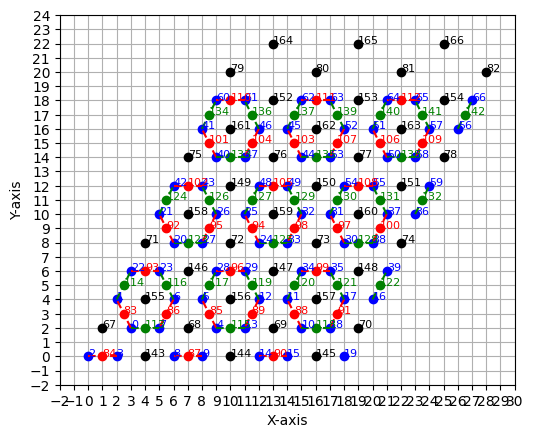

blue_Z_edge (After deduplication): {A:(B,B')}
83 : (0, 1)
84 : (2, 3)
85 : (4, 5)
86 : (6, 7)
87 : (8, 9)
88 : (10, 11)
89 : (12, 13)
90 : (14, 15)
91 : (17, 18)
92 : (20, 21)
93 : (22, 23)
94 : (24, 25)
95 : (26, 27)
96 : (28, 29)
97 : (30, 31)
98 : (32, 33)
99 : (34, 35)
100 : (37, 38)
101 : (40, 41)
102 : (42, 43)
103 : (44, 45)
104 : (46, 47)
105 : (48, 49)
106 : (50, 51)
107 : (52, 53)
108 : (54, 55)
109 : (57, 58)
110 : (60, 61)
111 : (62, 63)
112 : (64, 65)
green_X_edge (After deduplication): {A:(B,B')}
113 : (0, 7)
114 : (1, 22)
115 : (4, 13)
116 : (6, 23)
117 : (5, 28)
118 : (10, 18)
119 : (12, 29)
120 : (11, 34)
121 : (17, 35)
122 : (16, 39)
123 : (20, 27)
124 : (21, 42)
125 : (24, 33)
126 : (26, 43)
127 : (25, 48)
128 : (30, 38)
129 : (32, 49)
130 : (31, 54)
131 : (37, 55)
132 : (36, 59)
133 : (40, 47)
134 : (41, 60)
135 : (44, 53)
136 : (46, 61)
137 : (45, 62)
138 : (50, 58)
139 : (52, 63)
140 : (51, 64)
141 : (57, 65)
142 : (56, 66)
Total Qubits after deduplication and add

In [685]:
import math
import matplotlib.pyplot as plt


shift_dx, shift_dy = 6, 0
directions = [(2, 0), (1, 2), (-1, 2), (-2, 0), (-1, -2), (1, -2)]
paired_direction_sets = [
    [(2, 0), (1, 2)],
    [(-1, 2), (-2, 0)],
    [(-1, -2), (1, -2)]
]

data_qubits = []
ancilla_qubits = []
direction_map = []  # 各ancilla生成毎の(direction,生成data qubit index)記録

base_x, base_y = 1, 2
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n)]
current_data_index = 0

# --- 最初のブロック(ancilla + data生成) ---
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n):
        if step == 0:
            filtered_directions = [(2, 0), (1, 2), (-1, -2), (1, -2)]
        elif step == n - 1:
            filtered_directions = [(1, 2), (-1, 2), (-2, 0), (-1, -2)]
        else:
            filtered_directions = directions

        if point_index == len(initial_base_points) - 1:
            if step == n - 1:
                filtered_directions = [(-1, -2)]
            else:
                filtered_directions = [(-1, -2), (1, -2)]

        # Ancilla登録
        ancilla_qubits.append((base_x_current, base_y_current))
        temp_dir_record = []
        for dx, dy in filtered_directions:
            new_x = base_x_current + dx
            new_y = base_y_current + dy
            data_qubits.append((new_x, new_y))
            temp_dir_record.append((dx, dy, current_data_index))
            current_data_index += 1

        direction_map.append(temp_dir_record)
        base_x_current += shift_dx
        base_y_current += shift_dy

# edge辞書作成前に後続ブロックの追加は行わないため、ここではコメントアウト

# 最初のブロックから生成されたdata, ancillaを辞書化
data_qubit_dict = {i: coord for i, coord in enumerate(data_qubits)}
ancilla_qubit_dict_start = len(data_qubits)
ancilla_qubit_dict = {ancilla_qubit_dict_start + i: coord for i, coord in enumerate(ancilla_qubits)}
all_qubits_dict = {**data_qubit_dict, **ancilla_qubit_dict}

# blue_Z_edge生成
blue_Z_edge = {}
for ancilla_num, record in enumerate(direction_map):
    for pair_dirs in paired_direction_sets:
        indices_found = []
        for (dx,dy) in pair_dirs:
            for (rdx,rdy,di) in record:
                if rdx == dx and rdy == dy:
                    indices_found.append(di)
                    break
        if len(indices_found) == 2:
            B, Bp = indices_found
            x1,y1 = data_qubit_dict[B]
            x2,y2 = data_qubit_dict[Bp]
            mid_x = (x1+x2)/2.0
            mid_y = (y1+y2)/2.0
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (mid_x, mid_y)
            blue_Z_edge[A_index] = (B,Bp)

# green_X_edge生成 (最初のブロック生成のancillaのみ)
green_X_edge = {}
num_first_block_ancillas = len(initial_base_points)*n
first_block_ancillas = ancilla_qubits[:num_first_block_ancillas]

for i in range(num_first_block_ancillas):
    for j in range(i+1, num_first_block_ancillas):
        x1,y1 = first_block_ancillas[i]
        x2,y2 = first_block_ancillas[j]
        dx = x2 - x1
        dy = y2 - y1
        dist = math.sqrt(dx*dx + dy*dy)
        # 距離が6または3√5の場合のみ考慮
        if abs(dist - 6) < 1e-9 or abs(dist - 3*math.sqrt(5)) < 1e-9:
            selected_data = []
            for d_i,(xd,yd) in data_qubit_dict.items():
                # ancilla点と同一座標なら除外
                if (xd == x1 and yd == y1) or (xd == x2 and yd == y2):
                    continue
                # 直線上判定＋線分内判定
                if abs(dx*(yd - y1) - dy*(xd - x1)) < 1e-9:
                    if min(x1,x2) <= xd <= max(x1,x2) and min(y1,y2) <= yd <= max(y1,y2):
                        selected_data.append(d_i)
            # 必ず2個存在する場合のみ登録
            if len(selected_data) == 2:
                B,Bp = selected_data
                mid_x = (x1+x2)/2.0
                mid_y = (y1+y2)/2.0
                A_index = len(all_qubits_dict)
                all_qubits_dict[A_index] = (mid_x, mid_y)
                green_X_edge[A_index] = (B,Bp)

# ===== 重複アンシラ削除 =====
ancilla_start_index = ancilla_qubit_dict_start
ancilla_indices = [idx for idx in all_qubits_dict if idx >= ancilla_start_index]
coord_to_ancilla_index = {}
duplicates = {}

for A in ancilla_indices:
    coord = all_qubits_dict[A]
    if coord not in coord_to_ancilla_index:
        coord_to_ancilla_index[coord] = A
    else:
        duplicates[A] = coord_to_ancilla_index[coord]

# blue_Z_edge重複処理
for A in list(blue_Z_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A not in blue_Z_edge:
            blue_Z_edge[new_A] = blue_Z_edge[A]
        del blue_Z_edge[A]

# green_X_edge重複処理
for A in list(green_X_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A not in green_X_edge:
            green_X_edge[new_A] = green_X_edge[A]
        del green_X_edge[A]

for A in duplicates.keys():
    del all_qubits_dict[A]


# =====ここで、edge辞書作成後に base_sets に対応するアンシラを起きます=====
base_sets = [
    (4,0,n),
    (4,4,n),
]

for (bx, by, steps) in base_sets:
    initial_base_points = [(bx + 3 * i, by + 6 * i) for i in range(steps)]
    for p_i, (ibx, iby) in enumerate(initial_base_points):
        base_x_current = ibx
        base_y_current = iby
        for step in range(steps-1 if steps>1 else 0):
            # 後から追加のancilla
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (base_x_current, base_y_current)
            # この後追加するancillaはblue_Z_edgeやgreen_X_edge計算には関与しない
            base_x_current += shift_dx
            base_y_current += shift_dy

# 追加が終わったので、すべてのqubitを表示
fig, ax = plt.subplots()

# data_qubitsは青
for i,(x,y) in data_qubit_dict.items():
    ax.plot(x, y, 'bo')
    ax.text(x, y, str(i), color='blue', fontsize=8)

# ancilla開始インデックス再取得（基本変わらないが念のため）
ancilla_indices = [i for i in all_qubits_dict if i >= ancilla_start_index]

# 通常アンシラ(黒)
for A_index in ancilla_indices:
    if A_index not in blue_Z_edge and A_index not in green_X_edge:
        xA,yA = all_qubits_dict[A_index]
        ax.plot(xA, yA, 'ko')
        ax.text(xA, yA, str(A_index), color='black', fontsize=8)

# blue_Z_edge(赤)
for A_index,(B,Bp) in blue_Z_edge.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'ro')
    ax.text(xA, yA, str(A_index), color='red', fontsize=8)
    xB,yB = data_qubit_dict[B]
    xBp,yBp = data_qubit_dict[Bp]
    ax.plot([xB,xA,xBp],[yB,yA,yBp],'r--')

# green_X_edge(緑)
for A_index,(B,Bp) in green_X_edge.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'go')
    ax.text(xA, yA, str(A_index), color='green', fontsize=8)
    xB,yB = data_qubit_dict[B]
    xBp,yBp = data_qubit_dict[Bp]
    ax.plot([xB,xA,xBp],[yB,yA,yBp],'g--')

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True)

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

x_min = int(x_min) - 1
x_max = int(x_max) + 1
y_min = int(y_min) - 1
y_max = int(y_max) + 1

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(range(int(x_min), int(x_max)+1))
ax.set_yticks(range(int(y_min), int(y_max)+1))

plt.show()

print("blue_Z_edge (After deduplication): {A:(B,B')}")
for A,(B,Bp) in blue_Z_edge.items():
    print(A,":", (B,Bp))

print("green_X_edge (After deduplication): {A:(B,B')}")
for A,(B,Bp) in green_X_edge.items():
    print(A,":", (B,Bp))

print("Total Qubits after deduplication and addition:", len(all_qubits_dict))


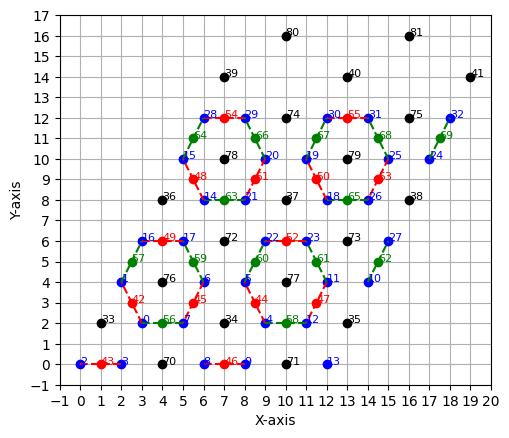

blue_Z_edge (After deduplication): {A:(B,B')}
42 : (0, 1)
43 : (2, 3)
44 : (4, 5)
45 : (6, 7)
46 : (8, 9)
47 : (11, 12)
48 : (14, 15)
49 : (16, 17)
50 : (18, 19)
51 : (20, 21)
52 : (22, 23)
53 : (25, 26)
54 : (28, 29)
55 : (30, 31)
green_X_edge (After deduplication): {A:(B,B')}
56 : (0, 7)
57 : (1, 16)
58 : (4, 12)
59 : (6, 17)
60 : (5, 22)
61 : (11, 23)
62 : (10, 27)
63 : (14, 21)
64 : (15, 28)
65 : (18, 26)
66 : (20, 29)
67 : (19, 30)
68 : (25, 31)
69 : (24, 32)
Total Qubits after deduplication and addition: 82

data_qubit_dict:
0 (3, 2)
1 (2, 4)
2 (0, 0)
3 (2, 0)
4 (9, 2)
5 (8, 4)
6 (6, 4)
7 (5, 2)
8 (6, 0)
9 (8, 0)
10 (14, 4)
11 (12, 4)
12 (11, 2)
13 (12, 0)
14 (6, 8)
15 (5, 10)
16 (3, 6)
17 (5, 6)
18 (12, 8)
19 (11, 10)
20 (9, 10)
21 (8, 8)
22 (9, 6)
23 (11, 6)
24 (17, 10)
25 (15, 10)
26 (14, 8)
27 (15, 6)
28 (6, 12)
29 (8, 12)
30 (12, 12)
31 (14, 12)
32 (18, 12)

ancilla_qubit_dict (including newly added ancillas):
33 (1, 2)
34 (7, 2)
35 (13, 2)
36 (4, 8)
37 (10, 8)
38 (16, 8)
39

In [686]:
import math
import matplotlib.pyplot as plt

# パラメータ
d = 5
n = (d + 1) / 2  # n = 3
n = int(n)

shift_dx, shift_dy = 6, 0
directions = [(2, 0), (1, 2), (-1, 2), (-2, 0), (-1, -2), (1, -2)]
paired_direction_sets = [
    [(2, 0), (1, 2)],
    [(-1, 2), (-2, 0)],
    [(-1, -2), (1, -2)]
]

data_qubits = []
ancilla_qubits = []
direction_map = []  # 各ancilla生成毎の(direction,生成data qubit index)記録

base_x, base_y = 1, 2
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n)]
current_data_index = 0

# --- 最初のブロック(ancilla + data生成) ---
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n):
        if step == 0:
            filtered_directions = [(2, 0), (1, 2), (-1, -2), (1, -2)]
        elif step == n - 1:
            filtered_directions = [(1, 2), (-1, 2), (-2, 0), (-1, -2)]
        else:
            filtered_directions = directions

        if point_index == len(initial_base_points) - 1:
            if step == n - 1:
                filtered_directions = [(-1, -2)]
            else:
                filtered_directions = [(-1, -2), (1, -2)]

        # Ancilla登録
        ancilla_qubits.append((base_x_current, base_y_current))
        temp_dir_record = []
        for dx, dy in filtered_directions:
            new_x = base_x_current + dx
            new_y = base_y_current + dy
            data_qubits.append((new_x, new_y))
            temp_dir_record.append((dx, dy, current_data_index))
            current_data_index += 1

        direction_map.append(temp_dir_record)
        base_x_current += shift_dx
        base_y_current += shift_dy

# data, ancilla辞書の初期構築
data_qubit_dict = {i: coord for i, coord in enumerate(data_qubits)}
ancilla_qubit_dict_start = len(data_qubits)
ancilla_qubit_dict = {ancilla_qubit_dict_start + i: coord for i, coord in enumerate(ancilla_qubits)}
all_qubits_dict = {**data_qubit_dict, **ancilla_qubit_dict}

# blue_Z_edge生成
blue_Z_edge = {}
for ancilla_num, record in enumerate(direction_map):
    for pair_dirs in paired_direction_sets:
        indices_found = []
        for (dx,dy) in pair_dirs:
            for (rdx,rdy,di) in record:
                if rdx == dx and rdy == dy:
                    indices_found.append(di)
                    break
        if len(indices_found) == 2:
            B, Bp = indices_found
            x1,y1 = data_qubit_dict[B]
            x2,y2 = data_qubit_dict[Bp]
            mid_x = (x1+x2)/2.0
            mid_y = (y1+y2)/2.0
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (mid_x, mid_y)
            blue_Z_edge[A_index] = (B,Bp)

# green_X_edge生成 (最初のブロック生成のancillaのみ)
green_X_edge = {}
num_first_block_ancillas = len(initial_base_points)*n
first_block_ancillas = ancilla_qubits[:num_first_block_ancillas]

for i in range(num_first_block_ancillas):
    for j in range(i+1, num_first_block_ancillas):
        x1,y1 = first_block_ancillas[i]
        x2,y2 = first_block_ancillas[j]
        dx = x2 - x1
        dy = y2 - y1
        dist = math.sqrt(dx*dx + dy*dy)
        # 距離が6または3√5の場合のみ考慮
        if abs(dist - 6) < 1e-9 or abs(dist - 3*math.sqrt(5)) < 1e-9:
            selected_data = []
            for d_i,(xd,yd) in data_qubit_dict.items():
                # ancilla点と同一座標なら除外
                if (xd == x1 and yd == y1) or (xd == x2 and yd == y2):
                    continue
                # 直線上判定＋線分内判定
                if abs(dx*(yd - y1) - dy*(xd - x1)) < 1e-9:
                    if min(x1,x2) <= xd <= max(x1,x2) and min(y1,y2) <= yd <= max(y1,y2):
                        selected_data.append(d_i)
            # 必ず2個存在する場合のみ登録
            if len(selected_data) == 2:
                B,Bp = selected_data
                mid_x = (x1+x2)/2.0
                mid_y = (y1+y2)/2.0
                A_index = len(all_qubits_dict)
                all_qubits_dict[A_index] = (mid_x, mid_y)
                green_X_edge[A_index] = (B,Bp)

# ===== 重複アンシラ削除 =====
ancilla_start_index = ancilla_qubit_dict_start
ancilla_indices = [idx for idx in all_qubits_dict if idx >= ancilla_start_index]
coord_to_ancilla_index = {}
duplicates = {}

for A in ancilla_indices:
    coord = all_qubits_dict[A]
    if coord not in coord_to_ancilla_index:
        coord_to_ancilla_index[coord] = A
    else:
        duplicates[A] = coord_to_ancilla_index[coord]

# blue_Z_edge重複処理
for A in list(blue_Z_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A not in blue_Z_edge:
            blue_Z_edge[new_A] = blue_Z_edge[A]
        del blue_Z_edge[A]

# green_X_edge重複処理
for A in list(green_X_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A not in green_X_edge:
            green_X_edge[new_A] = green_X_edge[A]
        del green_X_edge[A]

for A in duplicates.keys():
    del all_qubits_dict[A]

# edge辞書作成後にancilla追加 (base_sets)
base_sets = [
    (4,0,n),
    (4,4,n),
]

for (bx, by, steps) in base_sets:
    initial_base_points = [(bx + 3 * i, by + 6 * i) for i in range(steps)]
    for p_i, (ibx, iby) in enumerate(initial_base_points):
        base_x_current = ibx
        base_y_current = iby
        for step in range(steps-1 if steps>1 else 0):
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (base_x_current, base_y_current)
            base_x_current += shift_dx
            base_y_current += shift_dy

# ここで、新たに追加されたancilla(blue_Z_edge, green_X_edgeで生成したancilla + base_setsで追加したancilla)をancilla_qubit_dictに再反映
# data_qubit数は変わらず、全てのキー >= ancilla_qubit_dict_start をancillaとみなして再構築
ancilla_qubit_dict = {k: v for k, v in all_qubits_dict.items() if k >= ancilla_qubit_dict_start}

# プロット
fig, ax = plt.subplots()

# data_qubitsは青
for i,(x,y) in data_qubit_dict.items():
    ax.plot(x, y, 'bo')
    ax.text(x, y, str(i), color='blue', fontsize=8)

ancilla_indices = [i for i in all_qubits_dict if i >= ancilla_start_index]

# 通常アンシラ(黒)
for A_index in ancilla_indices:
    if A_index not in blue_Z_edge and A_index not in green_X_edge:
        xA,yA = all_qubits_dict[A_index]
        ax.plot(xA, yA, 'ko')
        ax.text(xA, yA, str(A_index), color='black', fontsize=8)

# blue_Z_edge(赤)
for A_index,(B,Bp) in blue_Z_edge.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'ro')
    ax.text(xA, yA, str(A_index), color='red', fontsize=8)
    xB,yB = data_qubit_dict[B]
    xBp,yBp = data_qubit_dict[Bp]
    ax.plot([xB,xA,xBp],[yB,yA,yBp],'r--')

# green_X_edge(緑)
for A_index,(B,Bp) in green_X_edge.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'go')
    ax.text(xA, yA, str(A_index), color='green', fontsize=8)
    xB,yB = data_qubit_dict[B]
    xBp,yBp = data_qubit_dict[Bp]
    ax.plot([xB,xA,xBp],[yB,yA,yBp],'g--')

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True)

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

x_min = int(x_min) - 1
x_max = int(x_max) + 1
y_min = int(y_min) - 1
y_max = int(y_max) + 1

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(range(int(x_min), int(x_max)+1))
ax.set_yticks(range(int(y_min), int(y_max)+1))

plt.show()

print("blue_Z_edge (After deduplication): {A:(B,B')}")
for A,(B,Bp) in blue_Z_edge.items():
    print(A,":", (B,Bp))

print("green_X_edge (After deduplication): {A:(B,B')}")
for A,(B,Bp) in green_X_edge.items():
    print(A,":", (B,Bp))

print("Total Qubits after deduplication and addition:", len(all_qubits_dict))

# 更新後の辞書を表示
print("\ndata_qubit_dict:")
for k,v in data_qubit_dict.items():
    print(k, v)

print("\nancilla_qubit_dict (including newly added ancillas):")
for k,v in ancilla_qubit_dict.items():
    print(k, v)


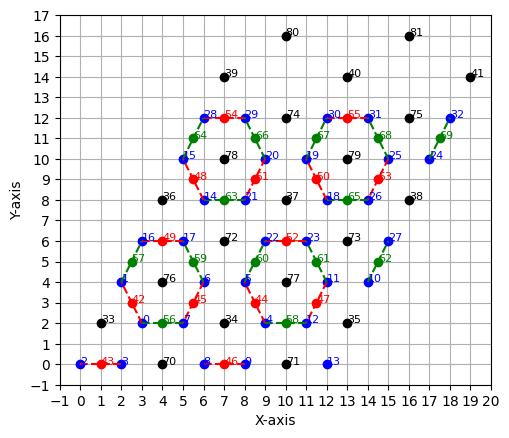

blue_Z_edge (After deduplication): {A:(B,B')}
42 : (0, 1)
43 : (2, 3)
44 : (4, 5)
45 : (6, 7)
46 : (8, 9)
47 : (11, 12)
48 : (14, 15)
49 : (16, 17)
50 : (18, 19)
51 : (20, 21)
52 : (22, 23)
53 : (25, 26)
54 : (28, 29)
55 : (30, 31)
green_X_edge (After deduplication): {A:(B,B')}
56 : (0, 7)
57 : (1, 16)
58 : (4, 12)
59 : (6, 17)
60 : (5, 22)
61 : (11, 23)
62 : (10, 27)
63 : (14, 21)
64 : (15, 28)
65 : (18, 26)
66 : (20, 29)
67 : (19, 30)
68 : (25, 31)
69 : (24, 32)
Total Qubits after deduplication and addition: 82

data_qubit_dict:
0 (3, 2)
1 (2, 4)
2 (0, 0)
3 (2, 0)
4 (9, 2)
5 (8, 4)
6 (6, 4)
7 (5, 2)
8 (6, 0)
9 (8, 0)
10 (14, 4)
11 (12, 4)
12 (11, 2)
13 (12, 0)
14 (6, 8)
15 (5, 10)
16 (3, 6)
17 (5, 6)
18 (12, 8)
19 (11, 10)
20 (9, 10)
21 (8, 8)
22 (9, 6)
23 (11, 6)
24 (17, 10)
25 (15, 10)
26 (14, 8)
27 (15, 6)
28 (6, 12)
29 (8, 12)
30 (12, 12)
31 (14, 12)
32 (18, 12)

ancilla_qubit_dict (including newly added ancillas):
33 (1, 2)
34 (7, 2)
35 (13, 2)
36 (4, 8)
37 (10, 8)
38 (16, 8)
39

In [687]:
import math
import matplotlib.pyplot as plt

# パラメータ
d = 5
n = (d + 1) / 2  # n = 3
n = int(n)

shift_dx, shift_dy = 6, 0
directions = [(2, 0), (1, 2), (-1, 2), (-2, 0), (-1, -2), (1, -2)]
paired_direction_sets = [
    [(2, 0), (1, 2)],
    [(-1, 2), (-2, 0)],
    [(-1, -2), (1, -2)]
]

data_qubits = []
ancilla_qubits = []
direction_map = []  # 各ancilla生成毎の(direction,生成data qubit index)記録

base_x, base_y = 1, 2
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n)]
current_data_index = 0

# --- 最初のブロック(ancilla + data生成) ---
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n):
        if step == 0:
            filtered_directions = [(2, 0), (1, 2), (-1, -2), (1, -2)]
        elif step == n - 1:
            filtered_directions = [(1, 2), (-1, 2), (-2, 0), (-1, -2)]
        else:
            filtered_directions = directions

        if point_index == len(initial_base_points) - 1:
            if step == n - 1:
                filtered_directions = [(-1, -2)]
            else:
                filtered_directions = [(-1, -2), (1, -2)]

        # Ancilla登録
        ancilla_qubits.append((base_x_current, base_y_current))
        temp_dir_record = []
        for dx, dy in filtered_directions:
            new_x = base_x_current + dx
            new_y = base_y_current + dy
            data_qubits.append((new_x, new_y))
            temp_dir_record.append((dx, dy, current_data_index))
            current_data_index += 1

        direction_map.append(temp_dir_record)
        base_x_current += shift_dx
        base_y_current += shift_dy

# data, ancilla辞書の初期構築
data_qubit_dict = {i: coord for i, coord in enumerate(data_qubits)}
ancilla_qubit_dict_start = len(data_qubits)
ancilla_qubit_dict = {ancilla_qubit_dict_start + i: coord for i, coord in enumerate(ancilla_qubits)}
all_qubits_dict = {**data_qubit_dict, **ancilla_qubit_dict}

# green_X_face生成 (data qubitが2個以下の時は登録しない)
green_X_face = {}
for i, record in enumerate(direction_map):
    ancilla_index = ancilla_qubit_dict_start + i
    data_indices = tuple(di for (dx, dy, di) in record)
    # ここでdata qubitが2個以下なら登録しない
    if len(data_indices) > 2:
        green_X_face[ancilla_index] = data_indices

# blue_Z_edge生成
blue_Z_edge = {}
for ancilla_num, record in enumerate(direction_map):
    for pair_dirs in paired_direction_sets:
        indices_found = []
        for (dx,dy) in pair_dirs:
            for (rdx,rdy,di) in record:
                if rdx == dx and rdy == dy:
                    indices_found.append(di)
                    break
        if len(indices_found) == 2:
            B, Bp = indices_found
            x1,y1 = data_qubit_dict[B]
            x2,y2 = data_qubit_dict[Bp]
            mid_x = (x1+x2)/2.0
            mid_y = (y1+y2)/2.0
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (mid_x, mid_y)
            blue_Z_edge[A_index] = (B,Bp)

# green_X_edge生成 (最初のブロック生成のancillaのみ)
green_X_edge = {}
num_first_block_ancillas = len(initial_base_points)*n
first_block_ancillas = ancilla_qubits[:num_first_block_ancillas]

for i in range(num_first_block_ancillas):
    for j in range(i+1, num_first_block_ancillas):
        x1,y1 = first_block_ancillas[i]
        x2,y2 = first_block_ancillas[j]
        dx = x2 - x1
        dy = y2 - y1
        dist = math.sqrt(dx*dx + dy*dy)
        # 距離が6または3√5の場合のみ考慮
        if abs(dist - 6) < 1e-9 or abs(dist - 3*math.sqrt(5)) < 1e-9:
            selected_data = []
            for d_i,(xd,yd) in data_qubit_dict.items():
                # ancilla点と同一座標なら除外
                if (xd == x1 and yd == y1) or (xd == x2 and yd == y2):
                    continue
                # 直線上判定＋線分内判定
                if abs(dx*(yd - y1) - dy*(xd - x1)) < 1e-9:
                    if min(x1,x2) <= xd <= max(x1,x2) and min(y1,y2) <= yd <= max(y1,y2):
                        selected_data.append(d_i)
            # 必ず2個存在する場合のみ登録
            if len(selected_data) == 2:
                B,Bp = selected_data
                mid_x = (x1+x2)/2.0
                mid_y = (y1+y2)/2.0
                A_index = len(all_qubits_dict)
                all_qubits_dict[A_index] = (mid_x, mid_y)
                green_X_edge[A_index] = (B,Bp)

# ===== 重複アンシラ削除 =====
ancilla_start_index = ancilla_qubit_dict_start
ancilla_indices = [idx for idx in all_qubits_dict if idx >= ancilla_start_index]
coord_to_ancilla_index = {}
duplicates = {}

for A in ancilla_indices:
    coord = all_qubits_dict[A]
    if coord not in coord_to_ancilla_index:
        coord_to_ancilla_index[coord] = A
    else:
        duplicates[A] = coord_to_ancilla_index[coord]

# blue_Z_edge重複処理
for A in list(blue_Z_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A not in blue_Z_edge:
            blue_Z_edge[new_A] = blue_Z_edge[A]
        del blue_Z_edge[A]

# green_X_edge重複処理
for A in list(green_X_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A not in green_X_edge:
            green_X_edge[new_A] = green_X_edge[A]
        del green_X_edge[A]

for A in duplicates.keys():
    del all_qubits_dict[A]

# edge辞書作成後にancilla追加 (base_sets)
base_sets = [
    (4,0,n),
    (4,4,n),
]

for (bx, by, steps) in base_sets:
    initial_base_points = [(bx + 3 * i, by + 6 * i) for i in range(steps)]
    for p_i, (ibx, iby) in enumerate(initial_base_points):
        base_x_current = ibx
        base_y_current = iby
        for step in range(steps-1 if steps>1 else 0):
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (base_x_current, base_y_current)
            base_x_current += shift_dx
            base_y_current += shift_dy

# ここで、新たに追加されたancilla(blue_Z_edge, green_X_edgeで生成したancilla + base_setsで追加したancilla)をancilla_qubit_dictに再反映
ancilla_qubit_dict = {k: v for k, v in all_qubits_dict.items() if k >= ancilla_qubit_dict_start}

# プロット
fig, ax = plt.subplots()

# data_qubitsは青
for i,(x,y) in data_qubit_dict.items():
    ax.plot(x, y, 'bo')
    ax.text(x, y, str(i), color='blue', fontsize=8)

ancilla_indices = [i for i in all_qubits_dict if i >= ancilla_start_index]

# 通常アンシラ(黒)
for A_index in ancilla_indices:
    if A_index not in blue_Z_edge and A_index not in green_X_edge:
        xA,yA = all_qubits_dict[A_index]
        ax.plot(xA, yA, 'ko')
        ax.text(xA, yA, str(A_index), color='black', fontsize=8)

# blue_Z_edge(赤)
for A_index,(B,Bp) in blue_Z_edge.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'ro')
    ax.text(xA, yA, str(A_index), color='red', fontsize=8)
    xB,yB = data_qubit_dict[B]
    xBp,yBp = data_qubit_dict[Bp]
    ax.plot([xB,xA,xBp],[yB,yA,yBp],'r--')

# green_X_edge(緑)
for A_index,(B,Bp) in green_X_edge.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'go')
    ax.text(xA, yA, str(A_index), color='green', fontsize=8)
    xB,yB = data_qubit_dict[B]
    xBp,yBp = data_qubit_dict[Bp]
    ax.plot([xB,xA,xBp],[yB,yA,yBp],'g--')

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True)

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

x_min = int(x_min) - 1
x_max = int(x_max) + 1
y_min = int(y_min) - 1
y_max = int(y_max) + 1

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(range(int(x_min), int(x_max)+1))
ax.set_yticks(range(int(y_min), int(y_max)+1))

plt.show()

print("blue_Z_edge (After deduplication): {A:(B,B')}")
for A,(B,Bp) in blue_Z_edge.items():
    print(A,":", (B,Bp))

print("green_X_edge (After deduplication): {A:(B,B')}")
for A,(B,Bp) in green_X_edge.items():
    print(A,":", (B,Bp))

print("Total Qubits after deduplication and addition:", len(all_qubits_dict))

# 更新後の辞書を表示
print("\ndata_qubit_dict:")
for k,v in data_qubit_dict.items():
    print(k, v)

print("\nancilla_qubit_dict (including newly added ancillas):")
for k,v in ancilla_qubit_dict.items():
    print(k, v)

print("\ngreen_X_face (data qubitが2個以下の時は表示しない):")
for k,v in green_X_face.items():
    print(k, v)


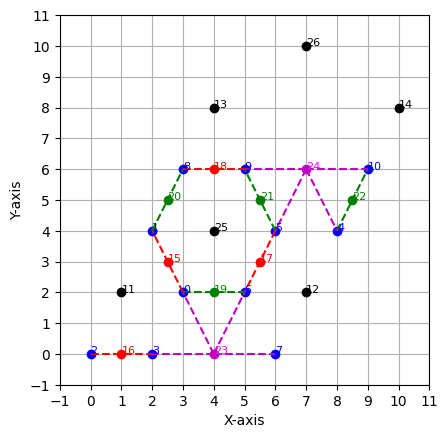

blue_Z_edge (After deduplication): {A:(B,B')}
15 : (0, 1)
16 : (2, 3)
17 : (5, 6)
18 : (8, 9)
green_X_edge (After deduplication): {A:(B,B')}
19 : (0, 6)
20 : (1, 8)
21 : (5, 9)
22 : (4, 10)
blue_Z_face ((4,0,n)で生成されたアンシラのみ処理):
23 : (7, 6, 0, 3)
24 : (10, 9, 5, 4)
Total Qubits after deduplication and addition: 27

data_qubit_dict:
0 (3, 2)
1 (2, 4)
2 (0, 0)
3 (2, 0)
4 (8, 4)
5 (6, 4)
6 (5, 2)
7 (6, 0)
8 (3, 6)
9 (5, 6)
10 (9, 6)

ancilla_qubit_dict (including newly added ancillas):
11 (1, 2)
12 (7, 2)
13 (4, 8)
14 (10, 8)
15 (2.5, 3.0)
16 (1.0, 0.0)
17 (5.5, 3.0)
18 (4.0, 6.0)
19 (4.0, 2.0)
20 (2.5, 5.0)
21 (5.5, 5.0)
22 (8.5, 5.0)
23 (4, 0)
24 (7, 6)
25 (4, 4)
26 (7, 10)

green_X_face:
11 (0, 1, 2, 3)
12 (4, 5, 6, 7)
13 (8, 9)
14 (10,)


In [688]:
import math
import matplotlib.pyplot as plt

# パラメータ
d = 3
n = (d + 1) / 2  # n = 3
n = int(n)

shift_dx, shift_dy = 6, 0
directions = [(2, 0), (1, 2), (-1, 2), (-2, 0), (-1, -2), (1, -2)]
paired_direction_sets = [
    [(2, 0), (1, 2)],
    [(-1, 2), (-2, 0)],
    [(-1, -2), (1, -2)]
]

data_qubits = []
ancilla_qubits = []
direction_map = []  # 各ancilla生成毎の(direction,生成data qubit index)記録

base_x, base_y = 1, 2
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n)]
current_data_index = 0

# --- 最初のブロック(ancilla + data生成) ---
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n):
        if step == 0:
            filtered_directions = [(2, 0), (1, 2), (-1, -2), (1, -2)]
        elif step == n - 1:
            filtered_directions = [(1, 2), (-1, 2), (-2, 0), (-1, -2)]
        else:
            filtered_directions = directions

        if point_index == len(initial_base_points) - 1:
            if step == n - 1:
                filtered_directions = [(-1, -2)]
            else:
                filtered_directions = [(-1, -2), (1, -2)]

        # Ancilla登録
        ancilla_qubits.append((base_x_current, base_y_current))
        temp_dir_record = []
        for dx, dy in filtered_directions:
            new_x = base_x_current + dx
            new_y = base_y_current + dy
            data_qubits.append((new_x, new_y))
            temp_dir_record.append((dx, dy, current_data_index))
            current_data_index += 1

        direction_map.append(temp_dir_record)
        base_x_current += shift_dx
        base_y_current += shift_dy

# data, ancilla辞書の初期構築
data_qubit_dict = {i: coord for i, coord in enumerate(data_qubits)}
ancilla_qubit_dict_start = len(data_qubits)
ancilla_qubit_dict = {ancilla_qubit_dict_start + i: coord for i, coord in enumerate(ancilla_qubits)}
all_qubits_dict = {**data_qubit_dict, **ancilla_qubit_dict}

# green_X_face生成
green_X_face = {}
for i, record in enumerate(direction_map):
    ancilla_index = ancilla_qubit_dict_start + i
    data_indices = tuple(di for (dx, dy, di) in record)
    green_X_face[ancilla_index] = data_indices

# blue_Z_edge生成
blue_Z_edge = {}
for ancilla_num, record in enumerate(direction_map):
    for pair_dirs in paired_direction_sets:
        indices_found = []
        for (dx,dy) in pair_dirs:
            for (rdx,rdy,di) in record:
                if rdx == dx and rdy == dy:
                    indices_found.append(di)
                    break
        if len(indices_found) == 2:
            B, Bp = indices_found
            x1,y1 = data_qubit_dict[B]
            x2,y2 = data_qubit_dict[Bp]
            mid_x = (x1+x2)/2.0
            mid_y = (y1+y2)/2.0
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (mid_x, mid_y)
            blue_Z_edge[A_index] = (B,Bp)

# green_X_edge生成 (最初のブロック生成のancillaのみ)
green_X_edge = {}
num_first_block_ancillas = len(initial_base_points)*n
first_block_ancillas = ancilla_qubits[:num_first_block_ancillas]

for i in range(num_first_block_ancillas):
    for j in range(i+1, num_first_block_ancillas):
        x1,y1 = first_block_ancillas[i]
        x2,y2 = first_block_ancillas[j]
        dx = x2 - x1
        dy = y2 - y1
        dist = math.sqrt(dx*dx + dy*dy)
        # 距離が6または3√5の場合のみ考慮
        if abs(dist - 6) < 1e-9 or abs(dist - 3*math.sqrt(5)) < 1e-9:
            selected_data = []
            for d_i,(xd,yd) in data_qubit_dict.items():
                # ancilla点と同一座標なら除外
                if (xd == x1 and yd == y1) or (xd == x2 and yd == y2):
                    continue
                # 直線上判定＋線分内判定
                if abs(dx*(yd - y1) - dy*(xd - x1)) < 1e-9:
                    if min(x1,x2) <= xd <= max(x1,x2) and min(y1,y2) <= yd <= max(y1,y2):
                        selected_data.append(d_i)
            # 必ず2個存在する場合のみ登録
            if len(selected_data) == 2:
                B,Bp = selected_data
                mid_x = (x1+x2)/2.0
                mid_y = (y1+y2)/2.0
                A_index = len(all_qubits_dict)
                all_qubits_dict[A_index] = (mid_x, mid_y)
                green_X_edge[A_index] = (B,Bp)

# ===== 重複アンシラ削除 =====
ancilla_start_index = ancilla_qubit_dict_start
ancilla_indices = [idx for idx in all_qubits_dict if idx >= ancilla_start_index]
coord_to_ancilla_index = {}
duplicates = {}

for A in ancilla_indices:
    coord = all_qubits_dict[A]
    if coord not in coord_to_ancilla_index:
        coord_to_ancilla_index[coord] = A
    else:
        duplicates[A] = coord_to_ancilla_index[coord]

# blue_Z_edge重複処理
for A in list(blue_Z_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A not in blue_Z_edge:
            blue_Z_edge[new_A] = blue_Z_edge[A]
        del blue_Z_edge[A]

# green_X_edge重複処理
for A in list(green_X_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A not in green_X_edge:
            green_X_edge[new_A] = green_X_edge[A]
        del green_X_edge[A]

for A in duplicates.keys():
    del all_qubits_dict[A]

# --- ここで (4,0,n) のみ処理 ---
base_sets_400n = [
    (4,0,n),
]

before_400n_count = len(all_qubits_dict)
for (bx, by, steps) in base_sets_400n:
    initial_base_points = [(bx + 3 * i, by + 6 * i) for i in range(steps)]
    for p_i, (ibx, iby) in enumerate(initial_base_points):
        base_x_current = ibx
        base_y_current = iby
        for step in range(steps-1 if steps>1 else 0):
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (base_x_current, base_y_current)
            base_x_current += shift_dx
            base_y_current += shift_dy

after_400n_count = len(all_qubits_dict)

# (4,0,n)で生成されたアンシラのみ抽出
added_ancillas_400n = [idx for idx in range(before_400n_count, after_400n_count)]

# blue_Z_face作成 (4,0,n)で生成されたアンシラのみ対象
blue_Z_face = {}
for A_index in added_ancillas_400n:
    ax, ay = all_qubits_dict[A_index]
    found_data_indices = []
    for (dx, dy) in directions:
        tx, ty = ax + dx, ay + dy
        for di, (xd, yd) in data_qubit_dict.items():
            if xd == tx and yd == ty:
                found_data_indices.append(di)
                break
    if len(found_data_indices) > 0:
        blue_Z_face[A_index] = tuple(found_data_indices)

# --- ここで (4,4,n) 処理 ---
base_sets_44n = [
    (4,4,n),
]

for (bx, by, steps) in base_sets_44n:
    initial_base_points = [(bx + 3 * i, by + 6 * i) for i in range(steps)]
    for p_i, (ibx, iby) in enumerate(initial_base_points):
        base_x_current = ibx
        base_y_current = iby
        for step in range(steps-1 if steps>1 else 0):
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (base_x_current, base_y_current)
            base_x_current += shift_dx
            base_y_current += shift_dy

ancilla_qubit_dict = {k: v for k, v in all_qubits_dict.items() if k >= ancilla_qubit_dict_start}

# プロット
fig, ax = plt.subplots()

# data_qubitsは青
for i,(x,y) in data_qubit_dict.items():
    ax.plot(x, y, 'bo')
    ax.text(x, y, str(i), color='blue', fontsize=8)

ancilla_indices = [i for i in all_qubits_dict if i >= ancilla_start_index]

# 通常アンシラ(黒)
for A_index in ancilla_indices:
    if A_index not in blue_Z_edge and A_index not in green_X_edge and A_index not in blue_Z_face:
        xA,yA = all_qubits_dict[A_index]
        ax.plot(xA, yA, 'ko')
        ax.text(xA, yA, str(A_index), color='black', fontsize=8)

# blue_Z_edge(赤)
for A_index,(B,Bp) in blue_Z_edge.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'ro')
    ax.text(xA, yA, str(A_index), color='red', fontsize=8)
    xB,yB = data_qubit_dict[B]
    xBp,yBp = data_qubit_dict[Bp]
    ax.plot([xB,xA,xBp],[yB,yA,yBp],'r--')

# green_X_edge(緑)
for A_index,(B,Bp) in green_X_edge.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'go')
    ax.text(xA, yA, str(A_index), color='green', fontsize=8)
    xB,yB = data_qubit_dict[B]
    xBp,yBp = data_qubit_dict[Bp]
    ax.plot([xB,xA,xBp],[yB,yA,yBp],'g--')

# blue_Z_face(紫)
for A_index, data_tuple in blue_Z_face.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'mo') # 紫丸
    ax.text(xA, yA, str(A_index), color='magenta', fontsize=8)
    for d_i in data_tuple:
        xd, yd = data_qubit_dict[d_i]
        ax.plot([xA, xd],[yA, yd],'m--')

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True)

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

x_min = int(x_min) - 1
x_max = int(x_max) + 1
y_min = int(y_min) - 1
y_max = int(y_max) + 1

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(range(int(x_min), int(x_max)+1))
ax.set_yticks(range(int(y_min), int(y_max)+1))

plt.show()

print("blue_Z_edge (After deduplication): {A:(B,B')}")
for A,(B,Bp) in blue_Z_edge.items():
    print(A,":", (B,Bp))

print("green_X_edge (After deduplication): {A:(B,B')}")
for A,(B,Bp) in green_X_edge.items():
    print(A,":", (B,Bp))

print("blue_Z_face ((4,0,n)で生成されたアンシラのみ処理):")
for A,data_tuple in blue_Z_face.items():
    print(A, ":", data_tuple)

print("Total Qubits after deduplication and addition:", len(all_qubits_dict))

# 更新後の辞書を表示
print("\ndata_qubit_dict:")
for k,v in data_qubit_dict.items():
    print(k, v)

print("\nancilla_qubit_dict (including newly added ancillas):")
for k,v in ancilla_qubit_dict.items():
    print(k, v)

print("\ngreen_X_face:")
for k,v in green_X_face.items():
    print(k, v)


In [689]:
# パラメータ
d = 5
n = (d + 1) / 2  # n = 3
n = int(n)

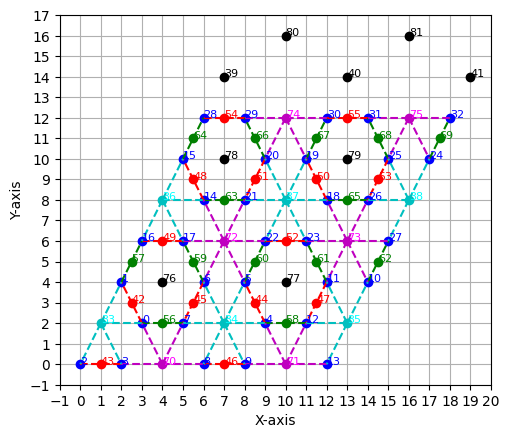

blue_Z_edge (After deduplication): {A:(B,B')}
42 : (0, 1)
43 : (2, 3)
44 : (4, 5)
45 : (6, 7)
46 : (8, 9)
47 : (11, 12)
48 : (14, 15)
49 : (16, 17)
50 : (18, 19)
51 : (20, 21)
52 : (22, 23)
53 : (25, 26)
54 : (28, 29)
55 : (30, 31)
green_X_edge (After deduplication): {A:(B,B')}
56 : (0, 7)
57 : (1, 16)
58 : (4, 12)
59 : (6, 17)
60 : (5, 22)
61 : (11, 23)
62 : (10, 27)
63 : (14, 21)
64 : (15, 28)
65 : (18, 26)
66 : (20, 29)
67 : (19, 30)
68 : (25, 31)
69 : (24, 32)
blue_Z_face ((4,0,n)で生成されたアンシラのみ処理, 並び替え後):
70 : [3, 0, 8, 7]
71 : [9, 4, 13, 12]
72 : [6, 22, 14, 5, 21, 17]
73 : [11, 27, 18, 10, 26, 23]
74 : [20, 29, 19, 30]
75 : [25, 31, 24, 32]
green_X_face (並び替え後・2個以下削除済み):
33 : [3, 0, 2, 1]
34 : [8, 4, 6, 9, 5, 7]
35 : [13, 10, 12, 11]
36 : [17, 14, 16, 15]
37 : [22, 18, 20, 23, 19, 21]
38 : [27, 24, 26, 25]
Total Qubits after deduplication and addition: 82

data_qubit_dict:
0 (3, 2)
1 (2, 4)
2 (0, 0)
3 (2, 0)
4 (9, 2)
5 (8, 4)
6 (6, 4)
7 (5, 2)
8 (6, 0)
9 (8, 0)
10 (14, 4)
11 (12, 4

In [690]:
import math
import matplotlib.pyplot as plt


shift_dx, shift_dy = 6, 0
directions = [(2, 0), (1, 2), (-1, 2), (-2, 0), (-1, -2), (1, -2)]
paired_direction_sets = [
    [(2, 0), (1, 2)],
    [(-1, 2), (-2, 0)],
    [(-1, -2), (1, -2)]
]

data_qubits = []
ancilla_qubits = []
direction_map = []  # 各ancilla生成毎 (最初のブロック)の(direction,生成data qubit index)記録

base_x, base_y = 1, 2
initial_base_points = [(base_x + 3 * i, base_y + 6 * i) for i in range(n)]
current_data_index = 0

# --- 最初のブロック(ancilla + data生成) ---
for point_index, (initial_base_x, initial_base_y) in enumerate(initial_base_points):
    base_x_current = initial_base_x
    base_y_current = initial_base_y
    for step in range(n):
        if step == 0:
            filtered_directions = [(2, 0), (1, 2), (-1, -2), (1, -2)]
        elif step == n - 1:
            filtered_directions = [(1, 2), (-1, 2), (-2, 0), (-1, -2)]
        else:
            filtered_directions = directions

        if point_index == len(initial_base_points) - 1:
            if step == n - 1:
                filtered_directions = [(-1, -2)]
            else:
                filtered_directions = [(-1, -2), (1, -2)]

        # Ancilla登録
        ancilla_qubits.append((base_x_current, base_y_current))
        temp_dir_record = []
        for dx, dy in filtered_directions:
            new_x = base_x_current + dx
            new_y = base_y_current + dy
            data_qubits.append((new_x, new_y))
            temp_dir_record.append((dx, dy, current_data_index))
            current_data_index += 1

        direction_map.append(temp_dir_record)
        base_x_current += shift_dx
        base_y_current += shift_dy

# data, ancilla辞書の初期構築
data_qubit_dict = {i: coord for i, coord in enumerate(data_qubits)}
ancilla_qubit_dict_start = len(data_qubits)
ancilla_qubit_dict = {ancilla_qubit_dict_start + i: coord for i, coord in enumerate(ancilla_qubits)}
all_qubits_dict = {**data_qubit_dict, **ancilla_qubit_dict}

# green_X_face: 最初のブロックで生成されたancillaについてdirection_mapから取得
green_X_face = {}
for i, record in enumerate(direction_map):
    ancilla_index = ancilla_qubit_dict_start + i
    green_X_face[ancilla_index] = [(dx, dy, di) for (dx, dy, di) in record]

# blue_Z_edge生成
blue_Z_edge = {}
for ancilla_num, record in enumerate(direction_map):
    for pair_dirs in paired_direction_sets:
        indices_found = []
        for (dx,dy) in pair_dirs:
            for (rdx,rdy,di) in record:
                if rdx == dx and rdy == dy:
                    indices_found.append(di)
                    break
        if len(indices_found) == 2:
            B, Bp = indices_found
            x1,y1 = data_qubit_dict[B]
            x2,y2 = data_qubit_dict[Bp]
            mid_x = (x1+x2)/2.0
            mid_y = (y1+y2)/2.0
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (mid_x, mid_y)
            blue_Z_edge[A_index] = (B,Bp)

# green_X_edge生成 (最初のブロック)
green_X_edge = {}
num_first_block_ancillas = len(initial_base_points)*n
first_block_ancillas = ancilla_qubits[:num_first_block_ancillas]

for i in range(num_first_block_ancillas):
    for j in range(i+1, num_first_block_ancillas):
        x1,y1 = first_block_ancillas[i]
        x2,y2 = first_block_ancillas[j]
        dx = x2 - x1
        dy = y2 - y1
        dist = math.sqrt(dx*dx + dy*dy)
        if abs(dist - 6) < 1e-9 or abs(dist - 3*math.sqrt(5)) < 1e-9:
            selected_data = []
            for d_i,(xd,yd) in data_qubit_dict.items():
                if (xd == x1 and yd == y1) or (xd == x2 and yd == y2):
                    continue
                if abs(dx*(yd - y1) - dy*(xd - x1)) < 1e-9:
                    if min(x1,x2) <= xd <= max(x1,x2) and min(y1,y2) <= yd <= max(y1,y2):
                        selected_data.append(d_i)
            if len(selected_data) == 2:
                B,Bp = selected_data
                mid_x = (x1+x2)/2.0
                mid_y = (y1+y2)/2.0
                A_index = len(all_qubits_dict)
                all_qubits_dict[A_index] = (mid_x, mid_y)
                green_X_edge[A_index] = (B,Bp)

# ===== 重複アンシラ削除 =====
ancilla_start_index = ancilla_qubit_dict_start
ancilla_indices = [idx for idx in all_qubits_dict if idx >= ancilla_start_index]
coord_to_ancilla_index = {}
duplicates = {}

for A in ancilla_indices:
    coord = all_qubits_dict[A]
    if coord not in coord_to_ancilla_index:
        coord_to_ancilla_index[coord] = A
    else:
        duplicates[A] = coord_to_ancilla_index[coord]

for A in list(blue_Z_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A not in blue_Z_edge:
            blue_Z_edge[new_A] = blue_Z_edge[A]
        del blue_Z_edge[A]

for A in list(green_X_edge.keys()):
    if A in duplicates:
        new_A = duplicates[A]
        if new_A not in green_X_edge:
            green_X_edge[new_A] = green_X_edge[A]
        del green_X_edge[A]

for A in duplicates.keys():
    del all_qubits_dict[A]

# (4,0,n)
base_sets_400n = [
    (4,0,n),
]

before_400n_count = len(all_qubits_dict)
for (bx, by, steps) in base_sets_400n:
    initial_base_points = [(bx + 3 * i, by + 6 * i) for i in range(steps)]
    for p_i, (ibx, iby) in enumerate(initial_base_points):
        base_x_current = ibx
        base_y_current = iby
        for step in range(steps-1 if steps>1 else 0):
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (base_x_current, base_y_current)
            base_x_current += shift_dx
            base_y_current += shift_dy

after_400n_count = len(all_qubits_dict)
added_ancillas_400n = [idx for idx in range(before_400n_count, after_400n_count)]

# blue_Z_face作成 (4,0,n)で生成されたアンシラのみ対象)
blue_Z_face = {}
for A_index in added_ancillas_400n:
    ax, ay = all_qubits_dict[A_index]
    found_list = []
    for (dx, dy) in directions:
        tx, ty = ax + dx, ay + dy
        for di,(xd,yd) in data_qubit_dict.items():
            if xd == tx and yd == ty:
                found_list.append(((dx,dy), di))
                break
    if len(found_list) > 0:
        blue_Z_face[A_index] = found_list  # [(direction, data_qubit), ...]

# (4,4,n)処理
base_sets_44n = [
    (4,4,n),
]

for (bx, by, steps) in base_sets_44n:
    initial_base_points = [(bx + 3 * i, by + 6 * i) for i in range(steps)]
    for p_i, (ibx, iby) in enumerate(initial_base_points):
        base_x_current = ibx
        base_y_current = iby
        for step in range(steps-1 if steps>1 else 0):
            A_index = len(all_qubits_dict)
            all_qubits_dict[A_index] = (base_x_current, base_y_current)
            base_x_current += shift_dx
            base_y_current += shift_dy

ancilla_qubit_dict = {k: v for k, v in all_qubits_dict.items() if k >= ancilla_qubit_dict_start}


###############################
# 並び替え処理
###############################
six_dir_order = [(-1,-2),(2,0),(-1,2),(1,-2),(1,2),(-2,0)]
green_4_dir_order_1 = [(1,-2),(2,0),(-1,-2),(1,2)]
green_4_dir_order_2 = [(-1,-2),(1,2),(-2,0),(-1,2)]
blue_4_dir_order_1 = [(-2,0),(-1,2),(2,0),(1,2)]
blue_4_dir_order_2 = [(-1,-2),(-2,0),(1,-2),(2,0)]

def reorder_face(face_dict, face_name):
    for A, lst in face_dict.items():
        if face_name == 'green_X_face':
            # lst = [(dx,dy,di), ...]
            dir_data_map = { (dx,dy): di for (dx,dy,di) in lst }
            directions_found = list(dir_data_map.keys())
        elif face_name == 'blue_Z_face':
            # lst = [((dx,dy), di), ...]
            dir_data_map = { d:di for (d,di) in lst }
            directions_found = list(dir_data_map.keys())
        else:
            # green_X_edgeなど
            # data qubitのみ
            continue

        count = len(directions_found)

        if count == 6:
            ordered = []
            for d in six_dir_order:
                if d in dir_data_map:
                    ordered.append(dir_data_map[d])
            face_dict[A] = ordered
        elif count == 4:
            if face_name == 'green_X_face':
                if all(d in dir_data_map for d in green_4_dir_order_1):
                    ordered = [dir_data_map[d] for d in green_4_dir_order_1]
                elif all(d in dir_data_map for d in green_4_dir_order_2):
                    ordered = [dir_data_map[d] for d in green_4_dir_order_2]
                else:
                    ordered = [di for di in dir_data_map.values()]
                face_dict[A] = ordered
            elif face_name == 'blue_Z_face':
                if all(d in dir_data_map for d in blue_4_dir_order_1):
                    ordered = [dir_data_map[d] for d in blue_4_dir_order_1]
                elif all(d in dir_data_map for d in blue_4_dir_order_2):
                    ordered = [dir_data_map[d] for d in blue_4_dir_order_2]
                else:
                    ordered = [di for di in dir_data_map.values()]
                face_dict[A] = ordered
        else:
            # 2個以下の場合green_X_faceは要らないため後で削除
            # blue_Z_faceは指定なし(2個以下もOKならそのまま)
            if face_name == 'green_X_face':
                # dataのみ抽出(だが2個以下は後で削除するためこのままでもOK)
                face_dict[A] = [di for (dx,dy,di) in lst]
            elif face_name == 'blue_Z_face':
                face_dict[A] = [di for (d,di) in lst]

# 並び替え
reorder_face(green_X_face, 'green_X_face')
reorder_face(blue_Z_face, 'blue_Z_face')

# green_X_faceについてdata qubitが2個以下のものは要らない
green_X_face = {A: v for A,v in green_X_face.items() if len(v) > 2}

# blue_Z_faceは特に指定なし（必要なら同様にフィルタリング可能）

# プロット
fig, ax = plt.subplots()

# data_qubitsは青
for i,(x,y) in data_qubit_dict.items():
    ax.plot(x, y, 'bo')
    ax.text(x, y, str(i), color='blue', fontsize=8)

ancilla_indices = [i for i in all_qubits_dict if i >= ancilla_start_index]

# 通常アンシラ(黒)
normal_ancillas = set(ancilla_indices) - set(blue_Z_edge.keys()) - set(green_X_edge.keys()) - set(blue_Z_face.keys()) - set(green_X_face.keys())
for A_index in normal_ancillas:
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'ko')
    ax.text(xA, yA, str(A_index), color='black', fontsize=8)

# blue_Z_edge(赤)
for A_index,(B,Bp) in blue_Z_edge.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'ro')
    ax.text(xA, yA, str(A_index), color='red', fontsize=8)
    xB,yB = data_qubit_dict[B]
    xBp,yBp = data_qubit_dict[Bp]
    ax.plot([xB,xA,xBp],[yB,yA,yBp],'r--')

# green_X_edge(緑)
for A_index,datapair in green_X_edge.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'go')
    ax.text(xA, yA, str(A_index), color='green', fontsize=8)
    if len(datapair) == 2:
        B,Bp = datapair
        xB,yB = data_qubit_dict[B]
        xBp,yBp = data_qubit_dict[Bp]
        ax.plot([xB,xA,xBp],[yB,yA,yBp],'g--')

# blue_Z_face(紫)
for A_index, data_list in blue_Z_face.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'mo')
    ax.text(xA, yA, str(A_index), color='magenta', fontsize=8)
    for d_i in data_list:
        xd, yd = data_qubit_dict[d_i]
        ax.plot([xA, xd],[yA, yd],'m--')

# green_X_face(シアン)
for A_index, data_list in green_X_face.items():
    xA,yA = all_qubits_dict[A_index]
    ax.plot(xA, yA, 'co')
    ax.text(xA, yA, str(A_index), color='cyan', fontsize=8)
    for d_i in data_list:
        xd, yd = data_qubit_dict[d_i]
        ax.plot([xA, xd],[yA, yd],'c--')

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.grid(True)

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

x_min = int(x_min) - 1
x_max = int(x_max) + 1
y_min = int(y_min) - 1
y_max = int(y_max) + 1

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(range(int(x_min), int(x_max)+1))
ax.set_yticks(range(int(y_min), int(y_max)+1))

plt.show()

print("blue_Z_edge (After deduplication): {A:(B,B')}")
for A,(B,Bp) in blue_Z_edge.items():
    print(A,":", (B,Bp))

print("green_X_edge (After deduplication): {A:(B,B')}")
for A,v in green_X_edge.items():
    print(A,":", v)

print("blue_Z_face ((4,0,n)で生成されたアンシラのみ処理, 並び替え後):")
for A,data_tuple in blue_Z_face.items():
    print(A, ":", data_tuple)

print("green_X_face (並び替え後・2個以下削除済み):")
for A,data_tuple in green_X_face.items():
    print(A, ":", data_tuple)

print("Total Qubits after deduplication and addition:", len(all_qubits_dict))

print("\ndata_qubit_dict:")
for k,v in data_qubit_dict.items():
    print(k, v)

print("\nancilla_qubit_dict (including newly added ancillas):")
for k,v in ancilla_qubit_dict.items():
    print(k, v)


In [691]:
def invert_y_sign(dictionary):
    return {key: (x, -y) for key, (x, y) in dictionary.items()}

data_qubits = invert_y_sign(data_qubit_dict)
ancilla_qubits = invert_y_sign(ancilla_qubit_dict)

In [692]:
import stim
import numpy as np
import pymatching
import sinter

In [693]:
import stim

# 回路の初期化
def initialize_circuit():
    return stim.Circuit()

# QUBIT_COORDS命令の追加
def append_qubit_coords(circuit, qubit_coords):
    for qubit, (x, y) in qubit_coords.items():
        circuit.append("QUBIT_COORDS", [qubit], [x, y])

# すべてのデータキュービットをリセット
def reset_data_qubits(circuit, data_qubits):
    for qubit in data_qubits:
        circuit.append("R", [qubit])

# すべてのアンシラキュービットをリセット
def reset_ancilla_qubits(circuit, ancilla_qubits):
    for qubit in ancilla_qubits:
        circuit.append("R", [qubit])

# シンドローム測定の追加
def append_syndrome_measurement(circuit, stabilizer, is_X_stabilizer=False, add_detector=False, interval = False):
    # CNOTゲートの適用の前後にHゲートを追加
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
        circuit.append("TICK")

    # CNOTゲートの適用
    max_iterations = max(len(data_qubits) for data_qubits in stabilizer.values())
    for i in range(max_iterations):
        for ancilla, data_qubits in stabilizer.items():
            if i < len(data_qubits):
                data_qubit = data_qubits[i]
                if is_X_stabilizer:
                    circuit.append("CX", [ancilla, data_qubit])
                else:
                    circuit.append("CX", [data_qubit, ancilla])
        circuit.append("TICK")

    # CNOTゲートの後にHゲートを追加
    if is_X_stabilizer:
        for ancilla in stabilizer.keys():
            circuit.append("H", [ancilla])
        circuit.append("TICK")

    # MR命令を追加
    for ancilla in stabilizer.keys():
        circuit.append("MR", [ancilla])
    circuit.append("TICK")  # MR命令と他の操作を分離

    # DETECTORの追加
    if add_detector:
        if not interval:
            for idx, ancilla in enumerate(stabilizer.keys()):
                circuit.append("DETECTOR", [stim.target_rec(-len(stabilizer) + idx), stim.target_rec(-len(stabilizer) + idx)])
        else:
            circuit.append("DETECTOR", [stim.target_rec(-4), stim.target_rec(-16)])
            circuit.append("DETECTOR", [stim.target_rec(-6), stim.target_rec(-18)])
            circuit.append("DETECTOR", [stim.target_rec(-3), stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-15), stim.target_rec(-13), stim.target_rec(-14)])
            circuit.append("DETECTOR", [stim.target_rec(-5), stim.target_rec(-17)])

# メイン関数
if __name__ == "__main__":
    circuit = initialize_circuit()

    color_face_Z_stabilizer = {
        12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)
    }
    color_face_X_stabilizer = {
        12: (2, 3, 5, 6), 13: (1, 2, 3, 4), 14: (3, 4, 6, 7)
    }
    step_1={12: (2, 3, 5, 6), 13: (1, 2, 3, 4, 8, 10), 14: (3, 4, 6, 7), 16: (8, 9, 10, 11)}
    step_2={12: (2, 3, 5, 6), 13: (1, 2, 3, 4, 8, 10), 14: (3, 4, 6, 7), 15: (4, 7, 10, 11), 22: (8, 10), 21: (9, 11)}
    floquet_Z={14: (3, 4, 6, 7), 16: (8, 9, 10, 11), 17: (5, 6), 18: (2, 3), 20: (1, 8), 19: (4, 10)}
    floquet_X={12: (2, 3, 5, 6), 15: (4, 7, 10, 11), 21: (9, 11), 22: (8, 10), 23: (1, 2), 24: (3, 4)}


    append_qubit_coords(circuit, data_qubits|ancilla_qubits)
    reset_data_qubits(circuit, data_qubits)
    reset_ancilla_qubits(circuit, ancilla_qubits)
    circuit.append("TICK")

    append_syndrome_measurement(circuit, green_X_edge|green_X_face, is_X_stabilizer=True)
    append_syndrome_measurement(circuit, blue_Z_edge|blue_Z_face)



    # 回路の表示
    print(circuit)

QUBIT_COORDS(3, -2) 0
QUBIT_COORDS(2, -4) 1
QUBIT_COORDS(0, 0) 2
QUBIT_COORDS(2, 0) 3
QUBIT_COORDS(9, -2) 4
QUBIT_COORDS(8, -4) 5
QUBIT_COORDS(6, -4) 6
QUBIT_COORDS(5, -2) 7
QUBIT_COORDS(6, 0) 8
QUBIT_COORDS(8, 0) 9
QUBIT_COORDS(14, -4) 10
QUBIT_COORDS(12, -4) 11
QUBIT_COORDS(11, -2) 12
QUBIT_COORDS(12, 0) 13
QUBIT_COORDS(6, -8) 14
QUBIT_COORDS(5, -10) 15
QUBIT_COORDS(3, -6) 16
QUBIT_COORDS(5, -6) 17
QUBIT_COORDS(12, -8) 18
QUBIT_COORDS(11, -10) 19
QUBIT_COORDS(9, -10) 20
QUBIT_COORDS(8, -8) 21
QUBIT_COORDS(9, -6) 22
QUBIT_COORDS(11, -6) 23
QUBIT_COORDS(17, -10) 24
QUBIT_COORDS(15, -10) 25
QUBIT_COORDS(14, -8) 26
QUBIT_COORDS(15, -6) 27
QUBIT_COORDS(6, -12) 28
QUBIT_COORDS(8, -12) 29
QUBIT_COORDS(12, -12) 30
QUBIT_COORDS(14, -12) 31
QUBIT_COORDS(18, -12) 32
QUBIT_COORDS(1, -2) 33
QUBIT_COORDS(7, -2) 34
QUBIT_COORDS(13, -2) 35
QUBIT_COORDS(4, -8) 36
QUBIT_COORDS(10, -8) 37
QUBIT_COORDS(16, -8) 38
QUBIT_COORDS(7, -14) 39
QUBIT_COORDS(13, -14) 40
QUBIT_COORDS(19, -14) 41
QUBIT_COORDS(2.5,

In [694]:
diagram = circuit.diagram("timeline-svg")
with open("circuit_timeline.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_timeline.svg", write_to="circuit_timeline.pdf")

diagram = circuit.diagram("detslice-svg")
with open("circuit_detslice.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice.svg", write_to="circuit_detslice.pdf")

diagram = circuit.without_noise().diagram(
    "detslice-with-ops-svg", 
    tick=range(0, 100),
)
with open("circuit_detslice-with-ops.svg", "w") as f:
    f.write(str(diagram))
# SVGからPDFに変換
import cairosvg
cairosvg.svg2pdf(url="circuit_detslice-with-ops.svg", write_to="circuit_detslice-with-ops.pdf")